In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import json 
import random 
from warnings import filterwarnings
filterwarnings('ignore')
import math
from datetime import datetime


In [2]:
config = json.loads(open('config.json').read()) 
train_set_path = config["local"]["train_set_path"]
test_set_path = config["local"]["test_set_path"]
val_set_path = config["local"]["val_set_path"]
model_path = config["local"]["model_path"]
train= True
save_model = True

In [3]:
# Data Augmentation and Rescaling for Training and Validation Sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)  # Just rescaling for validation data

# Create Training Set Generator
train_set = train_datagen.flow_from_directory(
    train_set_path,        # Path to the folder containing training images
    target_size=(150, 150),          # Resize images to 150x150
    batch_size=32,                   # Process 32 images per batch
    class_mode='binary'              # Binary classification (cats vs dogs)
)

#Validation Set
val_set = val_datagen.flow_from_directory(val_set_path,
                                           target_size=(150,150),
                                           batch_size = 32,
                                           class_mode='binary',
                                           shuffle=False)


# Define the CNN Model
classifier = Sequential([
    Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
# Compile the Model
classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

if train: 
    classifier.fit(
        train_set,
        steps_per_epoch=20,            
        epochs=10,           # set as 10 for now, if not v long training time               
        validation_data=val_set,            
        validation_steps=20                
    )
    if not os.path.exists(os.path.dirname(model_path)):
        os.makedirs(os.path.dirname(model_path))    
    if save_model:
        classifier.save(model_path)
else: 
    classifier = tf.keras.models.load_model(model_path)

Epoch 1/10
20/20 [==============================] - 13s 593ms/step - loss: 0.7804 - accuracy: 0.5234 - val_loss: 0.8229 - val_accuracy: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6901 - accuracy: 0.5125 - val_loss: 0.7420 - val_accuracy: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 13s 630ms/step - loss: 0.6910 - accuracy: 0.5531 - val_loss: 0.6827 - val_accuracy: 0.8547
Epoch 4/10
20/20 [==============================] - 12s 626ms/step - loss: 0.6853 - accuracy: 0.5469 - val_loss: 0.6604 - val_accuracy: 0.8109
Epoch 5/10
20/20 [==============================] - 11s 528ms/step - loss: 0.6928 - accuracy: 0.4984 - val_loss: 0.6826 - val_accuracy: 0.8891
Epoch 6/10
20/20 [==============================] - 11s 552ms/step - loss: 0.6907 - accuracy: 0.5203 - val_loss: 0.7022 - val_accuracy: 0.2359
Epoch 7/10
20/20 [==============================] - 11s 528ms/step - loss: 0.6913 - accuracy: 0.5234 - val_loss: 0.6222 - val_accuracy

### Prediction of Single Image

1/1 [==============================] - 0s 110ms/step


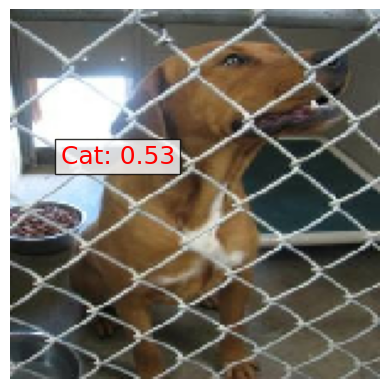

In [6]:
#get random image from train_set_folder
all_files = []
for root, dirs, files in os.walk(train_set_path):
    for file in files:
        all_files.append(os.path.join(root, file))  
img_path = random.choice(all_files)
img1 = image.load_img(img_path, target_size=(150, 150))  # Match target size with training size
img = image.img_to_array(img1)  # Convert image to array
img = img / 255.0  # Normalize the image

# Create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)

# Make prediction
prediction = classifier.predict(img)  # No need for batch_size or steps arguments

# Interpret the prediction
if prediction[0, 0] > 0.5:
    value = 'Dog: %1.2f' % prediction[0, 0]
    plt.text(20, 62, value, color='red', fontsize=18, bbox=dict(facecolor='white', alpha=0.8))
else:
    value = 'Cat: %1.2f' % (1.0 - prediction[0, 0])
    plt.text(20, 62, value, color='red', fontsize=18, bbox=dict(facecolor='white', alpha=0.8))

# Display the image
plt.imshow(img1)
plt.axis('off')  # Hide axes
plt.show()


In [7]:
# Reset the generator before prediction
val_set.reset()
steps = math.ceil(val_set.samples / val_set.batch_size)
# Use predict with steps argument
predictions = classifier.predict(val_set, steps=steps)
df = pd.DataFrame({
    'filename': val_set.filenames,
    'predict': predictions.flatten(),
    'y': val_set.classes
})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)
df.head(10)

157/157 [==============================] - 23s 143ms/step


,filename,predict,y,y_pred
0,cat/cat.100.jpg,0.35025,0,0
1,cat/cat.1000.jpg,0.24860,0,0
2,cat/cat.10000.jpg,0.13967,0,0
3,cat/cat.10010.jpg,0.43287,0,0
4,cat/cat.10017.jpg,0.28895,0,0
5,cat/cat.10022.jpg,0.34267,0,0
6,cat/cat.10024.jpg,0.29389,0,0
7,cat/cat.10031.jpg,0.33223,0,0
8,cat/cat.10040.jpg,0.29133,0,0
9,cat/cat.10051.jpg,0.34077,0,0


In [8]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 2082


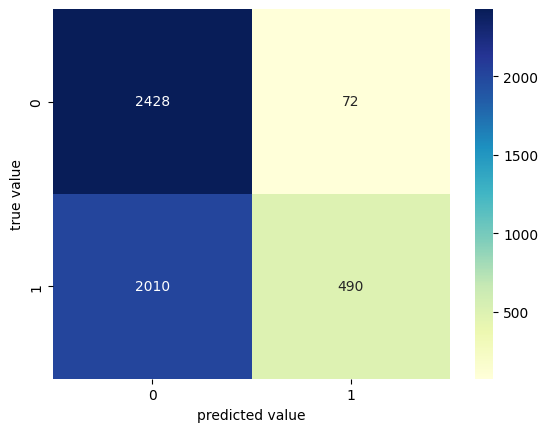

In [9]:
conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [10]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

### Model Performance on Unseen Data

1/1 [==============================] - 0s 50ms/step


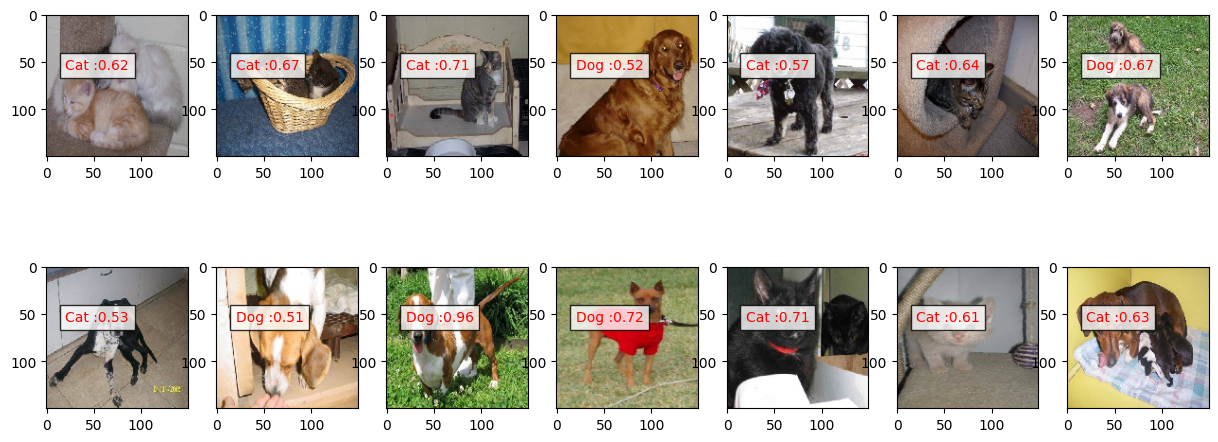

In [11]:
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 2
for root, dirs, files in os.walk(test_set_path):
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        img_path = f'{test_set_path}/{i+1}.jpg' 
        # Load and preprocess the image
        img1 = image.load_img(img_path, target_size=(150, 150))
        img = image.img_to_array(img1)
        img = img/255
        img = np.expand_dims(img, axis=0)
        prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
        if(prediction[:,:]>0.5):
            value ='Dog :%1.2f'%(prediction[0,0])
            plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
        else:
            value ='Cat :%1.2f'%(1.0-prediction[0,0])
            plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
        plt.imshow(img1)


In [12]:
# Model Accuracy
x1 = classifier.evaluate(train_set) 
x2 = classifier.evaluate(val_set)  
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(x2[1]*100,x2[0]))

157/157 [==============================] - 18s 114ms/step - loss: 0.6716 - accuracy: 0.5836
Training Accuracy  : 56.42%     Training loss  : 0.683050
Validation Accuracy: 58.36%     Validation loss: 0.671554


### Get predictions of test dataset 

In [13]:
predictions =  []
for file in os.listdir(test_set_path):
    img_path = os.path.join(test_set_path, file)
    img = image.load_img(img_path, target_size=(150, 150))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = classifier.predict(img)
    if prediction[0, 0] > 0.5:
        value = 'Dog'
    else:
        value = 'Cat'
    predictions.append({'filename': file, 'prediction': prediction[0, 0], 'class': value})
predictions = pd.DataFrame(predictions)
predictions.to_csv(f'{datetime.now().strftime("%Y%m%d_%H-%M-%S")}_predictions.csv', index=False)  

1/1 [==============================] - 0s 25ms/step
